In [3]:
%config IPCompleter.greedy=True
import os
import pygal
import numpy as np
import pandas as pd
import cairosvg
import datetime
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from scipy.stats import chisquare
path_datos = "/home/lalo/Documentos/Diplomado Ciencia de Datos/Modulo 1/Examen 2/"

tabla = pd.read_csv(path_datos + "movies.csv")

In [2]:
tabla.shape

(5043, 16)

# 1. Analisis Exploratorio de Datos

## 1.1 Indique cuales de las variables presentadas son discretas y cuales continuas.

In [3]:
tabla.columns
# Discretas. 'color', 'genre_4', 'genre_1', 'genre_2', 'genre_3', 'language','content_rating',
#           'facenumber_in_poster','movie_title', 'movie_imdb_link','title_year','imdb_score','country'
# Continuas.''gross', 'duration','num_voted_users'

Index(['movie_title', 'movie_imdb_link', 'color', 'genre_4', 'duration',
       'gross', 'genre_1', 'genre_2', 'genre_3', 'num_voted_users',
       'facenumber_in_poster', 'language', 'country', 'content_rating',
       'title_year', 'imdb_score'],
      dtype='object')

## 1.2 Realice una exploración visual ligera de los datos

In [4]:
ls_dis = ['color', 'genre_4', 'genre_1', 'genre_2', 'genre_3', 'language','content_rating',
          'facenumber_in_poster','movie_title', 'movie_imdb_link','title_year','imdb_score','country']

ls_cont = ['gross', 'duration','num_voted_users']
tabla_aux =  pd.DataFrame(tabla)

In [5]:
def Explo_light_Dis(var):
    path_img_hist = "/home/lalo/Documentos/Diplomado Ciencia de Datos/Modulo 1/Examen 2/Analisis exploratorio. Exploracion ligera/"
    tabla_aux[var] = tabla_aux[var].fillna('Sin '+ var)
       
    table_freq = pd.value_counts(tabla_aux[var]).to_frame().reset_index()
    table_freq.columns = ['Unicos','Conteo']

    line_chart = pygal.Bar()
    line_chart.title = 'grafica ' + var
    line_chart.x_labels = map(str, table_freq['Unicos'])
    line_chart.add( var,table_freq['Conteo'])
    
    nombre_grafica =  "Analisis_exploratorio_" + var
    line_chart.render_to_png(path_img_hist + nombre_grafica)

In [6]:
for var_dis in ls_dis:
    Explo_light_Dis(var_dis)

In [7]:
tabla_aux['num_voted_users'] = tabla_aux['num_voted_users'].convert_objects(convert_numeric=True)

/home/lalo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [8]:
tabla_aux['num_voted_users'] = tabla_aux['num_voted_users'].fillna(0)

In [9]:
tabla_aux['duration'].describe(percentiles = [x/10 for x in range(10)]+[0.01, 0.05, 0.95, 0.99]).apply("{0:,.1f}".format)
# 'gross', 'duration','num_voted_users'

count    5,028.0
mean       107.2
std         25.2
min          7.0
0%           7.0
1%          43.0
5%          81.0
10%         86.0
20%         91.0
30%         95.0
40%         99.0
50%        103.0
60%        108.0
70%        114.0
80%        122.0
90%        134.0
95%        146.0
99%        189.0
max        511.0
Name: duration, dtype: object

In [10]:
def Explo_light_Cont(var):
    path_img_hist = "/home/lalo/Documentos/Diplomado Ciencia de Datos/Modulo 1/Examen 2/Analisis exploratorio. Exploracion ligera/"

    fig = plt.hist(tabla_aux[var])
    nombre_grafica =  "Analisis_exploratorio_" + var
    plt.savefig(path_img_hist + nombre_grafica)
    

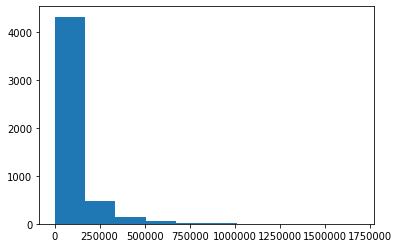

In [13]:
Explo_light_Cont('num_voted_users')

/home/lalo/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/lalo/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


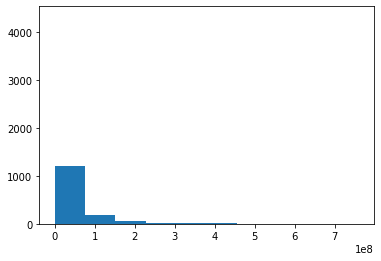

In [12]:
for var_cont in ls_cont:
    Explo_light_Cont(var_cont)

## 1.3 Remueva outliers de aquellas variables que los presenten.

In [14]:
# Solo aplica para continuas, entonces...
ls_cont = ['gross', 'duration','num_voted_users']
tabla_aux.shape

(5043, 16)

In [15]:
def New_poblacion_Met_2(data_origen, var, enes=3):
    data = pd.DataFrame(data_origen)
    registros_originales = 5043
    
    sigma = data[var].std()
    media = data[var].mean()
    lim_inf  = media - enes*sigma
    lim_sup = media + enes*sigma
    data = data[(lim_inf <= data[var])  & (data[var] <= lim_sup)]
    Nuevos_registros, Nuevas_columnas = data.shape
    
    return registros_originales, Nuevos_registros

In [16]:
Nuevos_universos_met_2 = {}
for var_cont in ls_cont:
    Nuevos_universos_met_2[var_cont] = [New_poblacion_Met_2(tabla_aux,var_cont,3)]
    
Nuevos_universos_met_2

{'gross': [(5043, 1472)],
 'duration': [(5043, 4930)],
 'num_voted_users': [(5043, 4932)]}

## 1.4 Normalice las variables discretas que lo requieran.

In [17]:
ls_dis = ['color', 'genre_4', 'genre_1', 'genre_2', 'genre_3', 'language','content_rating',
          'facenumber_in_poster','movie_title', 'movie_imdb_link','title_year','imdb_score','country']

In [56]:
def Freq_para_norm(var):
      
    table_freq = pd.value_counts(tabla_aux[var]).to_frame().reset_index()
    table_freq.columns = [var,'Conteo']

    table_porc = pd.value_counts(tabla_aux[var],normalize = True).to_frame().reset_index()
    table_porc.columns = [var,'Percent']

    table_salida = pd.merge(table_freq, table_porc, on=var)
    return table_salida

In [110]:
Freq_para_norm('color')
# No se normaliza

Variable  Conteo   Percent
0             Color    4815  0.954789
1   Black and White     209  0.041444
2         Sin color      19  0.003768

In [ ]:
# 'language'(0.003569),
# 'content_rating'(0.059885), 
# 'facenumber_in_poster'(0.022606),
# 'title_year', SAS
# 'imdb_score',SAS
# 'movie_imdb_link' SAS
# 'country'(0.010906),
# 'genre_1'(046004),
# 'genre_2'(0.042435),
# 'genre_3'(0.042435),
# 'genre_4'(0.042435)
Freq_para_norm('genre_4')

In [162]:
 Var_Dis_Normalizar = pd.DataFrame({'Variable':['language','content_rating','facenumber_in_poster','title_year','country','genre_1','genre_2','genre_3','genre_4'],
                                    'Bondades':[0.003569  ,0.059885        ,0.022606              ,0.010906    ,0.046004 ,0.042435 ,0.042435 ,0.042435 ,0.042435]})

# ls_Var_Dis_Normalizar = ['language','content_rating','facenumber_in_poster','title_year','country','genre_1','genre_2','genre_3','genre_4']
# ls_Bon_Dis_Normalizar = [0.003569  ,0.059885        ,0.022606              ,0.010906    ,0.046004 ,0.042435 ,0.042435 ,0.042435 ,0.042435]

Var_Dis_Normalizar

Variable  Bondades
0              language  0.003569
1        content_rating  0.059885
2  facenumber_in_poster  0.022606
3            title_year  0.010906
4               country  0.046004
5               genre_1  0.042435
6               genre_2  0.042435
7               genre_3  0.042435
8               genre_4  0.042435

In [ ]:
ls_disc_normalizar = ['genre_1','genre_2','genre_3','genre_4','language','content_rating',
                      'facenumber_in_poster','title_year','imdb_score','country']

 
ls_disc_NO_normalizar = ['color']
Freq_para_norm()

In [41]:
def Normalizar_Bondad(data):
    if data['Percent'] < Bondad:
        Normaliza = 'Otros'
    else: 
        Normaliza = data[var]
    return Normaliza

In [43]:
var = 'language'
Bondad = 0.003569

# def Normalizar(var,Bondad_var):
#     Bondad = Bondad_var
#     table_freq = pd.value_counts(tabla_aux[var]).to_frame().reset_index()
#     table_freq.columns = [var,'Conteo']

table_salida = pd.value_counts(tabla_aux[var],normalize = True).to_frame().reset_index()
table_salida.columns = [var,'Percent']    
table_salida[var + '_Norm'] = table_salida.apply(Normalizar_Bondad,axis=1)
Tabla_normalizada = pd.DataFrame(table_salida, columns = [var,var + '_Norm'])
tabla_aux = pd.merge(tabla_aux, Tabla_normalizada, on=var)
tabla_aux.columns

Index(['movie_title', 'movie_imdb_link', 'color', 'genre_4', 'duration',
       'gross', 'genre_1', 'genre_2', 'genre_3', 'num_voted_users',
       'facenumber_in_poster', 'language', 'country', 'content_rating',
       'title_year', 'imdb_score', 'language_Norm'],
      dtype='object')

In [45]:
# Normalizar('content_rating',0.059885)
var = 'content_rating'
Bondad = 0.059885

table_salida = pd.value_counts(tabla_aux[var],normalize = True).to_frame().reset_index()
table_salida.columns = [var,'Percent']    
table_salida[var + '_Norm'] = table_salida.apply(Normalizar_Bondad,axis=1)
Tabla_normalizada = pd.DataFrame(table_salida, columns = [var,var + '_Norm'])
tabla_aux = pd.merge(tabla_aux, Tabla_normalizada, on=var)
tabla_aux.columns

Index(['movie_title', 'movie_imdb_link', 'color', 'genre_4', 'duration',
       'gross', 'genre_1', 'genre_2', 'genre_3', 'num_voted_users',
       'facenumber_in_poster', 'language', 'country', 'content_rating',
       'title_year', 'imdb_score', 'language_Norm', 'content_rating_Norm'],
      dtype='object')

In [46]:
# Normalizar('facenumber_in_poster',0.022606)
var = 'facenumber_in_poster'
Bondad = 0.022606

table_salida = pd.value_counts(tabla_aux[var],normalize = True).to_frame().reset_index()
table_salida.columns = [var,'Percent']    
table_salida[var + '_Norm'] = table_salida.apply(Normalizar_Bondad,axis=1)
Tabla_normalizada = pd.DataFrame(table_salida, columns = [var,var + '_Norm'])
tabla_aux = pd.merge(tabla_aux, Tabla_normalizada, on=var)
tabla_aux.columns

Index(['movie_title', 'movie_imdb_link', 'color', 'genre_4', 'duration',
       'gross', 'genre_1', 'genre_2', 'genre_3', 'num_voted_users',
       'facenumber_in_poster', 'language', 'country', 'content_rating',
       'title_year', 'imdb_score', 'language_Norm', 'content_rating_Norm',
       'facenumber_in_poster_Norm'],
      dtype='object')

In [47]:
# Normalizar('title_year',0.010906)
var = 'title_year'
Bondad = 0.010906

table_salida = pd.value_counts(tabla_aux[var],normalize = True).to_frame().reset_index()
table_salida.columns = [var,'Percent']    
table_salida[var + '_Norm'] = table_salida.apply(Normalizar_Bondad,axis=1)
Tabla_normalizada = pd.DataFrame(table_salida, columns = [var,var + '_Norm'])
tabla_aux = pd.merge(tabla_aux, Tabla_normalizada, on=var)
tabla_aux.columns


Index(['movie_title', 'movie_imdb_link', 'color', 'genre_4', 'duration',
       'gross', 'genre_1', 'genre_2', 'genre_3', 'num_voted_users',
       'facenumber_in_poster', 'language', 'country', 'content_rating',
       'title_year', 'imdb_score', 'language_Norm', 'content_rating_Norm',
       'facenumber_in_poster_Norm', 'title_year_Norm'],
      dtype='object')

In [48]:
# Normalizar('country',0.046004)
var = 'country'
Bondad = 0.046004

table_salida = pd.value_counts(tabla_aux[var],normalize = True).to_frame().reset_index()
table_salida.columns = [var,'Percent']    
table_salida[var + '_Norm'] = table_salida.apply(Normalizar_Bondad,axis=1)
Tabla_normalizada = pd.DataFrame(table_salida, columns = [var,var + '_Norm'])
tabla_aux = pd.merge(tabla_aux, Tabla_normalizada, on=var)
tabla_aux.columns

Index(['movie_title', 'movie_imdb_link', 'color', 'genre_4', 'duration',
       'gross', 'genre_1', 'genre_2', 'genre_3', 'num_voted_users',
       'facenumber_in_poster', 'language', 'country', 'content_rating',
       'title_year', 'imdb_score', 'language_Norm', 'content_rating_Norm',
       'facenumber_in_poster_Norm', 'title_year_Norm', 'country_Norm'],
      dtype='object')

In [49]:
# Normalizar('genre_1',0.042435)
var = 'genre_1'
Bondad = 0.042435

table_salida = pd.value_counts(tabla_aux[var],normalize = True).to_frame().reset_index()
table_salida.columns = [var,'Percent']    
table_salida[var + '_Norm'] = table_salida.apply(Normalizar_Bondad,axis=1)
Tabla_normalizada = pd.DataFrame(table_salida, columns = [var,var + '_Norm'])
tabla_aux = pd.merge(tabla_aux, Tabla_normalizada, on=var)
tabla_aux.columns

Index(['movie_title', 'movie_imdb_link', 'color', 'genre_4', 'duration',
       'gross', 'genre_1', 'genre_2', 'genre_3', 'num_voted_users',
       'facenumber_in_poster', 'language', 'country', 'content_rating',
       'title_year', 'imdb_score', 'language_Norm', 'content_rating_Norm',
       'facenumber_in_poster_Norm', 'title_year_Norm', 'country_Norm',
       'genre_1_Norm'],
      dtype='object')

In [50]:
# Normalizar('genre_2',0.042435)
var = 'genre_2'
Bondad = 0.042435

table_salida = pd.value_counts(tabla_aux[var],normalize = True).to_frame().reset_index()
table_salida.columns = [var,'Percent']    
table_salida[var + '_Norm'] = table_salida.apply(Normalizar_Bondad,axis=1)
Tabla_normalizada = pd.DataFrame(table_salida, columns = [var,var + '_Norm'])
tabla_aux = pd.merge(tabla_aux, Tabla_normalizada, on=var)
tabla_aux.columns

Index(['movie_title', 'movie_imdb_link', 'color', 'genre_4', 'duration',
       'gross', 'genre_1', 'genre_2', 'genre_3', 'num_voted_users',
       'facenumber_in_poster', 'language', 'country', 'content_rating',
       'title_year', 'imdb_score', 'language_Norm', 'content_rating_Norm',
       'facenumber_in_poster_Norm', 'title_year_Norm', 'country_Norm',
       'genre_1_Norm', 'genre_2_Norm'],
      dtype='object')

In [51]:
# Normalizar('genre_3',0.042435)
var = 'genre_3'
Bondad = 0.042435

table_salida = pd.value_counts(tabla_aux[var],normalize = True).to_frame().reset_index()
table_salida.columns = [var,'Percent']    
table_salida[var + '_Norm'] = table_salida.apply(Normalizar_Bondad,axis=1)
Tabla_normalizada = pd.DataFrame(table_salida, columns = [var,var + '_Norm'])
tabla_aux = pd.merge(tabla_aux, Tabla_normalizada, on=var)
tabla_aux.columns

Index(['movie_title', 'movie_imdb_link', 'color', 'genre_4', 'duration',
       'gross', 'genre_1', 'genre_2', 'genre_3', 'num_voted_users',
       'facenumber_in_poster', 'language', 'country', 'content_rating',
       'title_year', 'imdb_score', 'language_Norm', 'content_rating_Norm',
       'facenumber_in_poster_Norm', 'title_year_Norm', 'country_Norm',
       'genre_1_Norm', 'genre_2_Norm', 'genre_3_Norm'],
      dtype='object')

In [52]:
# Normalizar('genre_4',0.042435)
var = 'genre_4'
Bondad = 0.042435

table_salida = pd.value_counts(tabla_aux[var],normalize = True).to_frame().reset_index()
table_salida.columns = [var,'Percent']    
table_salida[var + '_Norm'] = table_salida.apply(Normalizar_Bondad,axis=1)
Tabla_normalizada = pd.DataFrame(table_salida, columns = [var,var + '_Norm'])
tabla_aux = pd.merge(tabla_aux, Tabla_normalizada, on=var)
tabla_aux.columns

Index(['movie_title', 'movie_imdb_link', 'color', 'genre_4', 'duration',
       'gross', 'genre_1', 'genre_2', 'genre_3', 'num_voted_users',
       'facenumber_in_poster', 'language', 'country', 'content_rating',
       'title_year', 'imdb_score', 'language_Norm', 'content_rating_Norm',
       'facenumber_in_poster_Norm', 'title_year_Norm', 'country_Norm',
       'genre_1_Norm', 'genre_2_Norm', 'genre_3_Norm', 'genre_4_Norm'],
      dtype='object')

In [57]:
var = 'language'
var_norm = var + '_Norm'
Freq_para_norm(var_norm)

language_Norm  Conteo   Percent
0       English    4703  0.932580
1         Otros     136  0.026968
2        French      73  0.014476
3       Spanish      40  0.007932
4         Hindi      28  0.005552
5      Mandarin      26  0.005156
6        German      19  0.003768
7      Japanese      18  0.003569

In [58]:
var = 'content_rating'
var_norm = var + '_Norm'
Freq_para_norm(var_norm)

content_rating_Norm  Conteo   Percent
0                   R    2118  0.419988
1               PG-13    1461  0.289709
2               Otros     763  0.151299
3                  PG     701  0.139005

In [59]:
var = 'language'
var_norm = var + '_Norm'
Freq_para_norm(var_norm)


language_Norm  Conteo   Percent
0       English    4703  0.932580
1         Otros     136  0.026968
2        French      73  0.014476
3       Spanish      40  0.007932
4         Hindi      28  0.005552
5      Mandarin      26  0.005156
6        German      19  0.003768
7      Japanese      18  0.003569

In [60]:
var = 'facenumber_in_poster'
var_norm = var + '_Norm'
Freq_para_norm(var_norm)

facenumber_in_poster_Norm  Conteo   Percent
0                         0    2152  0.426730
1                         1    1251  0.248067
2                         2     716  0.141979
3                         3     380  0.075352
4                     Otros     337  0.066825
5                         4     207  0.041047

In [62]:
var = 'country'
var_norm = var + '_Norm'
Freq_para_norm(var_norm)

country_Norm  Conteo   Percent
0          USA    3806  0.754709
1        Otros     789  0.156454
2           UK     448  0.088836

In [63]:
var = 'genre_1'
var_norm = var + '_Norm'
Freq_para_norm(var_norm)

genre_1_Norm  Conteo   Percent
0       Comedy    1329  0.263534
1       Action    1153  0.228634
2        Drama     972  0.192742
3    Adventure     453  0.089827
4        Crime     349  0.069205
5        Otros     303  0.060083
6    Biography     252  0.049970
7       Horror     232  0.046004

In [64]:
var = 'genre_2'
var_norm = var + '_Norm'
Freq_para_norm(var_norm)

genre_2_Norm  Conteo   Percent
0        Otros    1381  0.273845
1        Drama    1204  0.238747
2  Sin genre_2     633  0.125521
3    Adventure     470  0.093198
4        Crime     410  0.081301
5      Romance     390  0.077335
6       Comedy     341  0.067618
7       Horror     214  0.042435

In [65]:
var = 'genre_3'
var_norm = var + '_Norm'
Freq_para_norm(var_norm)

genre_3_Norm  Conteo   Percent
0  Sin genre_3    1988  0.394210
1        Otros    1192  0.236367
2     Thriller     539  0.106881
3      Romance     468  0.092802
4        Drama     365  0.072378
5       Sci-Fi     275  0.054531
6      Fantasy     216  0.042832

In [66]:
var = 'genre_4'
var_norm = var + '_Norm'
Freq_para_norm(var_norm)

genre_4_Norm  Conteo   Percent
0  Sin genre_4    3616  0.717034
1        Otros     946  0.187587
2     Thriller     481  0.095380

## 1.5 Realice una nueva exploración visual, esta vez con el objetivo de ver los efectos de los tratamientos realizados. De igual modo, agregue las imágenes correspondientes.

In [68]:
ls_disc_normalizar = ['genre_1','genre_2','genre_3','genre_4','language','content_rating',
                      'facenumber_in_poster','country']

In [72]:
def Explo_light_Dis2(var):
    path_img_hist = "/home/lalo/Documentos/Diplomado Ciencia de Datos/Modulo 1/Examen 2/Analisis exploratorio. Exploracion ligera/"
       
    table_freq = pd.value_counts(tabla_aux[var]).to_frame().reset_index()
    table_freq.columns = ['Unicos','Conteo']

    line_chart = pygal.Bar()
    line_chart.title = 'grafica ' + var
    line_chart.x_labels = map(str, table_freq['Unicos'])
    line_chart.add(var,table_freq['Conteo'])
    
    nombre_grafica =  "Analisis_exploratorio_" + var
    line_chart.render_to_png(path_img_hist + nombre_grafica)



In [73]:
for var_dis in ls_disc_normalizar:
    var_norm = var_dis + '_Norm'
    Explo_light_Dis2(var_norm)

# 2. Ingenierìa de Datos

## 2.1 Cree una variable binaria que indique sı́ el score de la pelı́cula es mayor al promedio. Analice gráficamente la frecuencia de los valores generados.

In [74]:
tabla = pd.read_csv(path_datos + "movies.csv")

In [ ]:
tabla['Prom_Scpre'] =  tabla_aux['imdb_score'].mean()

In [11]:
tabla['flag_may_prom'] =np.where(tabla['imdb_score'] > tabla['Prom_Scpre'],1,0)

In [12]:
table_freq = pd.value_counts(tabla['flag_may_prom']).to_frame().reset_index()
table_freq.columns = ['Score_mayor_prom','Conteo']
table_freq

Score_mayor_prom  Conteo
0                 1    2744
1                 0    2299

In [14]:
table_salida = pd.value_counts(tabla['flag_may_prom'],normalize = True).to_frame().reset_index()
table_salida.columns = ['Score_mayor_prom','Percent']
table_salida

Score_mayor_prom   Percent
0                 1  0.544121
1                 0  0.455879

In [16]:
line_chart = pygal.Bar()
path_img_hist = "/home/lalo/Documentos/Diplomado Ciencia de Datos/Modulo 1/Examen 2/Examen 2 Cesar Meza/"
line_chart.title = ' '
line_chart.x_labels = map(str, table_freq['Score_mayor_prom'])
line_chart.add('Score_mayor_prom',table_freq['Conteo'])
nombre_grafica =  "Freq score de peliculas mayor al promedio"
line_chart.render_to_png(path_img_hist + nombre_grafica)

# 3. Tratamiento de valores ausentes

## 3.1 Elimine aquellas columnas que superen el umbral de 70% o más de presencia de valores ausentes. Indique que columnas fueron eliminadas.

In [134]:
ls_dis = ['color', 'genre_4', 'genre_1', 'genre_2', 'genre_3', 'language','content_rating',
          'facenumber_in_poster','movie_title', 'movie_imdb_link','title_year','imdb_score','country']

ls_cont = ['gross', 'duration','num_voted_users']

tabla = pd.read_csv(path_datos + "movies.csv")
tabla_aux =  pd.DataFrame(tabla)


In [129]:
var_elimi = tabla_aux.isnull().sum() / len(tabla_aux)
var_elimi

movie_title             0.000000
movie_imdb_link         0.000000
color                   0.003768
genre_4                 0.717034
duration                0.002974
gross                   0.701567
genre_1                 0.000000
genre_2                 0.125521
genre_3                 0.394210
num_voted_users         0.000000
facenumber_in_poster    0.002380
language                0.002380
country                 0.000991
content_rating          0.059885
title_year              0.021416
imdb_score              0.000000
dtype: float64

In [135]:
# Las variables eliminadas son: genre_4 y gross
tabla_aux = tabla_aux.drop(columns = ['genre_4', 'gross'])
var_elimi = tabla_aux.isnull().sum() / len(tabla_aux)
var_elimi

movie_title             0.000000
movie_imdb_link         0.000000
color                   0.003768
duration                0.002974
genre_1                 0.000000
genre_2                 0.125521
genre_3                 0.394210
num_voted_users         0.000000
facenumber_in_poster    0.002380
language                0.002380
country                 0.000991
content_rating          0.059885
title_year              0.021416
imdb_score              0.000000
dtype: float64

## 3.2 Impute las variables discretas que lo requieran mediante el uso de la moda. La variable imputada debe almacenarse en una variable nueva, dejando a la original intacta. 

In [101]:
ls_dis_new = ['color', 'genre_1', 'genre_2', 'genre_3', 'language','content_rating',
          'facenumber_in_poster','movie_title', 'movie_imdb_link','title_year','imdb_score','country']

In [136]:
for var_input_moda in ls_dis_new:
    tabla_aux['Moda_'+var_input_moda] = tabla_aux[var_input_moda].fillna(tabla_aux[var_input_moda].mode()[0])
    
tabla_aux.columns

Index(['movie_title', 'movie_imdb_link', 'color', 'duration', 'genre_1',
       'genre_2', 'genre_3', 'num_voted_users', 'facenumber_in_poster',
       'language', 'country', 'content_rating', 'title_year', 'imdb_score',
       'Moda_color', 'Moda_genre_1', 'Moda_genre_2', 'Moda_genre_3',
       'Moda_language', 'Moda_content_rating', 'Moda_facenumber_in_poster',
       'Moda_movie_title', 'Moda_movie_imdb_link', 'Moda_title_year',
       'Moda_imdb_score', 'Moda_country'],
      dtype='object')

## 3.3 Impute las variables continuas que lo requieran mediante el uso de la mediana. La variable imputada debe almacenarse en una variable nueva, dejando a la original intacta. 

In [118]:
ls_cont_new = ['duration','num_voted_users']
tabla_aux.shape

(5043, 28)

In [138]:
tabla_aux['num_voted_users'] = tabla_aux['num_voted_users'].convert_objects(convert_numeric=True)

/home/lalo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [139]:
tabla_aux['num_voted_users'].describe(percentiles = [x/10 for x in range(10)]+[0.01, 0.05, 0.95, 0.99]).apply("{0:,.1f}".format)

count        5,042.0
mean        83,684.7
std        138,494.0
min              5.0
0%               5.0
1%              54.2
5%             520.1
10%          1,649.7
20%          5,637.4
30%         12,241.9
40%         21,491.0
50%         34,371.0
60%         53,214.6
70%         78,001.7
80%        124,136.0
90%        216,571.5
95%        332,265.4
99%        681,112.4
max      1,689,764.0
Name: num_voted_users, dtype: object

In [122]:
tabla_aux['duration'] = tabla_aux['duration'].convert_objects(convert_numeric=True)
tabla_aux['duration'].describe

/home/lalo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


<bound method NDFrame.describe of 0       114.0
1       108.0
2        96.0
3       100.0
4       132.0
5        86.0
6        99.0
7       113.0
8       104.0
9        42.0
10       97.0
11      112.0
12      101.0
13      106.0
14       90.0
15       60.0
16      108.0
17       94.0
18       94.0
19      101.0
20       89.0
21      109.0
22       93.0
23       90.0
24      135.0
25      103.0
26      140.0
27       97.0
28      194.0
29      104.0
        ...  
5013    116.0
5014     83.0
5015     82.0
5016     99.0
5017     90.0
5018     96.0
5019     95.0
5020    106.0
5021     99.0
5022     90.0
5023     90.0
5024     92.0
5025    135.0
5026     88.0
5027    144.0
5028     87.0
5029    109.0
5030    128.0
5031     22.0
5032    121.0
5033    100.0
5034    119.0
5035    118.0
5036    186.0
5037    109.0
5038     44.0
5039    118.0
5040    103.0
5041     98.0
5042    101.0
Name: duration, Length: 5043, dtype: float64>

In [116]:
tabla_aux['duration'].describe(percentiles = [x/10 for x in range(10)]+[0.01, 0.05, 0.95, 0.99]).apply("{0:,.1f}".format)

count    5,028.0
mean       107.2
std         25.2
min          7.0
0%           7.0
1%          43.0
5%          81.0
10%         86.0
20%         91.0
30%         95.0
40%         99.0
50%        103.0
60%        108.0
70%        114.0
80%        122.0
90%        134.0
95%        146.0
99%        189.0
max        511.0
Name: duration, dtype: object

In [ ]:
# Si se van a imputar los missings, entonces seràn muy pocos:
# 'num_voted_users' solo serà 1 valor inputado 
# 'duration' 15
# Entonces:

In [146]:
tabla_aux['num_voted_users'].median()

34371.0

In [147]:
tabla_aux['Med_num_voted_users'] = tabla_aux['num_voted_users'].fillna(tabla_aux['num_voted_users'].median())

In [148]:
tabla_aux['Med_duration'] = tabla_aux['duration']
tabla_aux['Med_duration'] = tabla_aux['Med_duration'].fillna(tabla_aux['Med_duration'].median())

tabla_aux.columns

Index(['movie_title', 'movie_imdb_link', 'color', 'duration', 'genre_1',
       'genre_2', 'genre_3', 'num_voted_users', 'facenumber_in_poster',
       'language', 'country', 'content_rating', 'title_year', 'imdb_score',
       'Moda_color', 'Moda_genre_1', 'Moda_genre_2', 'Moda_genre_3',
       'Moda_language', 'Moda_content_rating', 'Moda_facenumber_in_poster',
       'Moda_movie_title', 'Moda_movie_imdb_link', 'Moda_title_year',
       'Moda_imdb_score', 'Moda_country', 'Med_duration',
       'Med_num_voted_users'],
      dtype='object')

## 3.4 Impute las variables continuas que lo requieran mediante el uso de la media. La variable imputada debe almacenarse en una variable nueva, dejando a la original intacta. 

In [153]:
tabla_aux['num_voted_users'].mean()

83684.7286790956

In [154]:
tabla_aux['Media_num_voted_users'] = tabla_aux['num_voted_users'].fillna(tabla_aux['num_voted_users'].mean())
tabla_aux['Media_duration'] = tabla_aux['duration'].fillna(tabla_aux['duration'].mean())
tabla_aux.columns

Index(['movie_title', 'movie_imdb_link', 'color', 'duration', 'genre_1',
       'genre_2', 'genre_3', 'num_voted_users', 'facenumber_in_poster',
       'language', 'country', 'content_rating', 'title_year', 'imdb_score',
       'Moda_color', 'Moda_genre_1', 'Moda_genre_2', 'Moda_genre_3',
       'Moda_language', 'Moda_content_rating', 'Moda_facenumber_in_poster',
       'Moda_movie_title', 'Moda_movie_imdb_link', 'Moda_title_year',
       'Moda_imdb_score', 'Moda_country', 'Med_duration',
       'Med_num_voted_users', 'Media_num_voted_users', 'Media_duration'],
      dtype='object')

# 4 Reducciòn de Dimensiones

## 4.1 A partir de las variables continuas, reduzca el dimensiones y visualice los datos en un gráfico de 2D

##  4.2 Mediante el uso de pruebas de poder predictivo, ordene las variables continuas contra el score de la pelı́cula.

## 4.3 Mediante el uso de transformación entrópica, seleccione las 5 variables más potentes contra la variable binaria creada previamente. Considere las variables con el siguiente tratamiento: sin valores atı́picos, normalizadas y con missings. Muestre un cuadro con el poder predictivo de las variables.

In [ ]:
Feedback:
En lo personal, la segunda parte del mòdulo, no me gusto mucho, creo que bajaste mucho el ritmo y por lo mismo,
no vimos los temas que nos hubiera encantado a todos ver. La ùltima clase te fuiste muy ràpido, me hubiera
encantado hacer un ejercicio sobre la reducciòn de dimensiones ya que creo que es un tema muy tocado 
en el mercado laboral.

